In [1]:
import glob
import os
import re

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# --- FUNCTION to preprocess .txt files for consistent delimiters


def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [3]:
# --- read in flux data
# flux data are colum integrated fluxes with all timesteps in a single file


# where results are stored
results_path = "example_3-3-15xRadius_site8"  #  "example_5-2-A1-bas-150rad-100cmMix_site1" # "example_3-3-15xRadius_site8"
flx_path, prof_path = os.path.join(results_path, "flx"), os.path.join(
    results_path, "prof"
)

# define file name pattern
fn_pref = [
    "int_flx_co2sp",
    "flx_co2sp",
]  # will read in all species unless fn_varInclude is defined
fn_varInclude = []
varCheck = True if len(fn_varInclude) > 0 else False
fn_ext = ".txt"

# loop through variables
df = pd.DataFrame()  # initialize empty df to store dat
for fset in fn_pref:
    # set pattern
    fn_pattern = f"{fset}-*{fn_ext}"
    # get list of filenames
    file_paths = glob.glob(f"{flx_path}/{fn_pattern}")

    # read in data and concatenate
    for file_path in file_paths:
        # get the variable
        varpattern = re.escape(fset) + r"-(.*?).txt"
        varmatch = re.search(varpattern, file_path)
        var = varmatch.group(1)
        # skip this step if it's not in the include arr
        if varCheck:
            if var not in fn_varInclude:
                continue
        # read in
        dfi = preprocess_txt(file_path)
        # apply pd.to_numeric to all columns using the "map" method
        dfi = dfi.map(pd.to_numeric)
        # add set and var
        dfi["set"] = fset
        dfi["var"] = var
        # combine
        df = pd.concat([df, dfi], ignore_index=True)

# sort by time and depth
df = df.sort_values(by=["var", "time"])
df

,time,tflx,adv,dif,rain,amsi,cc,dlm,tm,ka,...,ab,g2,fo,an,fa,gt,fe2o2,res,set,var
248,0.001111,-0.324426,0.352313,6.191943e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000454,int_flx_co2sp,ALK
620,0.001111,-0.323062,0.351034,6.140164e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000447,flx_co2sp,ALK
249,0.011111,-0.256189,0.290942,5.234076e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000128,int_flx_co2sp,ALK
621,0.011111,-0.248607,0.284124,5.127646e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000092,flx_co2sp,ALK
250,0.092994,-0.131856,0.203157,9.652339e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000334,int_flx_co2sp,ALK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,110.141295,0.001344,1.513667,1.696377e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.024266,flx_co2sp,hco3
122,115.067818,0.003085,1.007897,2.141638e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012427,int_flx_co2sp,hco3
494,115.067818,0.001267,1.543319,1.662747e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.025217,flx_co2sp,hco3
123,120.139239,0.003007,1.031134,2.058182e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012988,int_flx_co2sp,hco3


In [4]:
# --- compute the change in CO2 relative to t=0 in diffusion and advection
# create new column
pvars = ["co2g", "DIC"]
flxtype = ["dif", "adv"]  # these align with pvars

# loop through pvars
for tdx in range(len(pvars)):
    thisvar = pvars[tdx]
    thisflx = flxtype[tdx]
    thiscolname = thisflx + "_" + thisvar + "_change"
    df[thiscolname] = 0.0  # initialize column

    # loop through sets
    for dset in pd.unique(df["set"]):
        # subset data
        cond = (df["set"] == dset) & (df["var"] == thisvar)
        dfx = df[cond]
        # get initial flux
        diff_init = dfx.loc[dfx["time"].idxmin(), thisflx]
        # fill in new column
        df.loc[cond, thiscolname] = df.loc[cond, thisflx] - diff_init

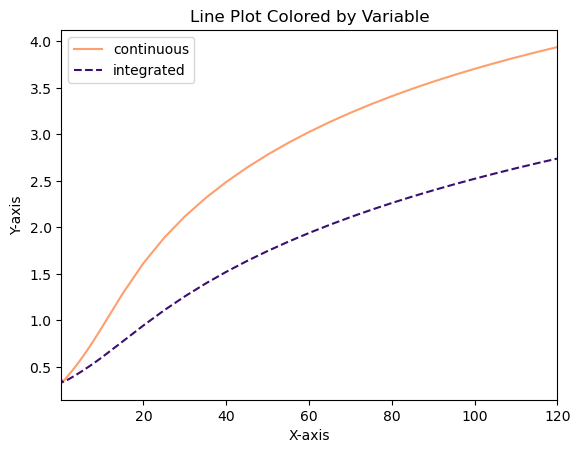

In [8]:
# --- plot single flux (lines colored by the set)
pvar = "DIC"  # variable to plot
pfluxtype = "adv"  # column name to plot (usually dif or adv)

# aesthetics
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# plot prep
dfx = df[df["var"] == pvar]
# split into integrated and continuous
dfxc = dfx[dfx["set"] == "flx_co2sp"]
dfxi = dfx[dfx["set"] == "int_flx_co2sp"]
num_sets = 2
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
plt.plot(dfxc["time"], dfxc[pfluxtype], color=cmap(0.2), label="continuous")
plt.plot(
    dfxi["time"],
    dfxi[pfluxtype],
    color=cmap(0.8),
    linestyle="dashed",
    label="integrated",
)

# Add labels and title
plt.xlabel("X-axis")
plt.xlim((0.2, 120))
plt.ylabel("Y-axis")
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();


# --- PLOT
# Create a plot for each time step
# for i, (name, group) in enumerate(grouped):
#     cmap_percentage = start_percentage + i * (end_percentage - start_percentage) / (num_sets - 1)
#     color = cmap(cmap_percentage)
#     plt.plot(group['time'], group[pfluxtype], color=color, label=name)
# plt.plot(group['gt'], group['z'], color=color, linestyle='dashed', label=None)

# Add labels and title
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Line Plot Colored by Variable')
# Add legend
# plt.legend()
# plt.show();

In [9]:
# --- compute CDR following Kanzaki / Baek (not accounting for respiration change here because T is held constant)
difcol, advcol = "dif_co2g_change", "adv_DIC_change"
difvar, advvar = "co2g", "DIC"
adv_lossFactor = 0  # fraction of advected C that we lose (Baek et al., 2023 use 0.14)

# loop through sets
outdf = pd.DataFrame()  # initialize empty df to store dat
for dset in pd.unique(df["set"]):
    # subset data
    dif_cond = (df["set"] == dset) & (df["var"] == difvar)
    adv_cond = (df["set"] == dset) & (df["var"] == advvar)
    # create output df
    dif_df = df.loc[dif_cond, ["time", difcol]]
    adv_df = df.loc[adv_cond, ["time", advcol]]
    outdf_i = pd.merge(dif_df, adv_df, on="time", how="outer")
    # compute cdr
    outdf_i["cdr_mol_m2_yr"] = -1 * outdf_i[difcol] + outdf_i[advcol] * (
        1 - adv_lossFactor
    )
    # add set
    outdf_i["set"] = dset
    # get output dataset
    outdf = pd.concat([outdf, outdf_i], ignore_index=True)

# convert to tons / ha / yr
co2_g_mol = 44.01
ton_g = 1 / 1e6
m2_ha = 10e3
outdf["cdr_ton_ha_yr"] = outdf["cdr_mol_m2_yr"] * co2_g_mol * ton_g * m2_ha
outdf

,time,dif_co2g_change,adv_DIC_change,cdr_mol_m2_yr,set,cdr_ton_ha_yr
0,0.001111,0.000000,0.000000,0.000000,int_flx_co2sp,0.000000
1,0.011111,0.127647,-0.058777,-0.186424,int_flx_co2sp,-0.082045
2,0.092994,0.197468,-0.145307,-0.342774,int_flx_co2sp,-0.150855
3,0.174877,0.190866,-0.163001,-0.353866,int_flx_co2sp,-0.155737
4,0.267174,0.182061,-0.173182,-0.355242,int_flx_co2sp,-0.156342
...,...,...,...,...,...,...
119,100.143352,-19.584926,3.186171,22.771096,flx_co2sp,10.021560
120,105.069875,-19.767757,3.248454,23.016212,flx_co2sp,10.129435
121,110.141295,-19.941662,3.309170,23.250831,flx_co2sp,10.232691
122,115.067818,-20.098779,3.365138,23.463916,flx_co2sp,10.326470


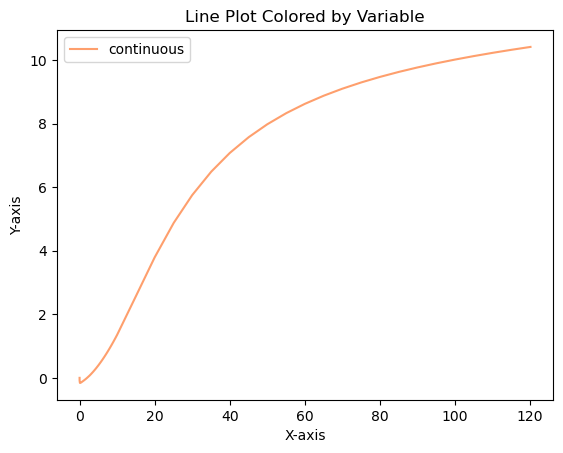

In [10]:
# --- plot CDR (lines colored by the set)
cdvar = "cdr_ton_ha_yr"  # variable to plot

# aesthetics
logX = False
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# split into integrated vs continuous fluxes
outdfc = outdf[outdf["set"] == "flx_co2sp"]
outdfi = outdf[outdf["set"] == "int_flx_co2sp"]
num_sets = 2
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
plt.plot(outdfc["time"], outdfc[cdvar], color=cmap(0.2), label="continuous")
# plt.plot(outdfi['time'], outdfi[cdvar]*outdfi['time'], color=cmap(0.8), label="integrated")

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
    plt.ylim([0.0001, 15])
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();

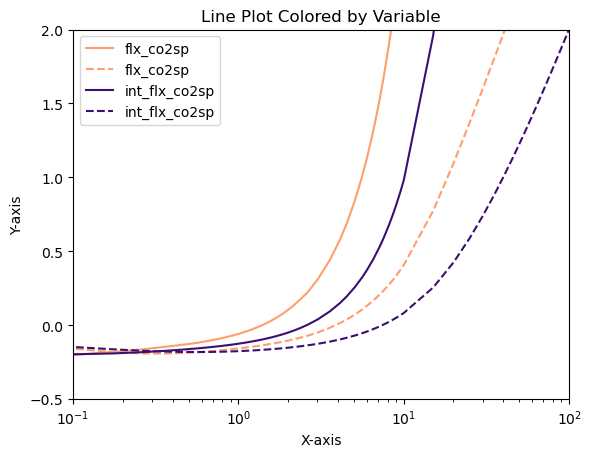

In [11]:
# --- plot individual contributions to CDR
difcol, advcol = "dif_co2g_change", "adv_DIC_change"  # variable to plot
cdvar = "cdr_ton_ha_yr"  # variable to plot

# aesthetics
logX = True
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# plot prep
grouped = outdf.groupby("set")
num_sets = len(grouped)
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
for i, (name, group) in enumerate(grouped):
    cmap_percentage = start_percentage + i * (end_percentage - start_percentage) / (
        num_sets - 1
    )
    color = cmap(cmap_percentage)
    plt.plot(group["time"], group[difcol] * -1, color=color, label=name, linestyle="-")
    plt.plot(
        group["time"],
        group[advcol] * (1 - adv_lossFactor),
        color=color,
        label=name,
        linestyle="--",
    )


# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
plt.ylim([-0.5, 2])
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();

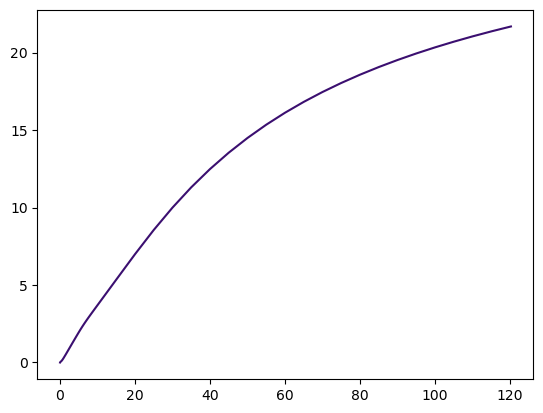

In [171]:
plt.plot(group["time"], group[cdvar], color=color, label=name)

In [170]:
group

,time,dif_co2g_change,adv_DIC_change,cdr_mol_m2_yr,set,cdr_ton_ha_yr
0,0.001111,0.000000,0.000000e+00,0.000000,int_flx_co2sp,0.000000
1,0.003026,-0.002024,9.777405e-07,0.002025,int_flx_co2sp,0.000891
2,0.010069,-0.005748,2.196623e-05,0.005770,int_flx_co2sp,0.002540
3,0.030576,-0.012755,1.611817e-04,0.012916,int_flx_co2sp,0.005684
4,0.050194,-0.017698,3.304539e-04,0.018028,int_flx_co2sp,0.007934
...,...,...,...,...,...,...
59,100.028801,-16.360641,3.978193e+00,20.338834,int_flx_co2sp,8.951121
60,105.019451,-16.667042,4.037652e+00,20.704693,int_flx_co2sp,9.112135
61,110.010101,-16.953145,4.094122e+00,21.047267,int_flx_co2sp,9.262902
62,115.271717,-17.235073,4.150706e+00,21.385780,int_flx_co2sp,9.411882


In [135]:
# subset data
pvar = "co2g"
colname = "dif_" + pvar + "_change"
df[colname] = 0.0

cond = (df["set"] == "int_flx_co2sp") & (df["var"] == "co2g")
dfx = df[cond]
# get initial flux
diff_init = dfx.loc[dfx["time"].idxmin(), "dif"]
# fill in new column
df.loc[cond, colname] = df.loc[cond, "dif"] - diff_init
df.loc[cond, colname]

0      0.000000
1     -0.002024
2     -0.005748
3     -0.012755
4     -0.017698
        ...    
59   -16.360641
60   -16.667042
61   -16.953145
62   -17.235073
63   -17.487820
Name: dif_co2g_change, Length: 64, dtype: float64